In [ ]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from sklearn import preprocessing

from datetime import datetime, timedelta
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<b> Project by <br>
  Bhavarth Chauhan(112671613) <br> Yasha Singh(112970310)<br>
  Sharvil Katariya(112950477) <br> Prateek Narendra(112687058) </b>

# <b>Cleaning and Outlier Detection</b>


In [ ]:
covid_df = pd.read_csv('https://raw.githubusercontent.com/datadesk/california-coronavirus-data/master/cdph-state-totals.csv')
covid_df['date'] = pd.to_datetime(covid_df['date'])  
covid_df = covid_df[['confirmed_cases', 'deaths','latino_cases_percent','black_cases_percent','asian_cases_percent','white_cases_percent','date']]
covid_df = covid_df[covid_df['date'] > pd.Timestamp(2020, 3,1)]

In [ ]:
air_quality_df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTmQ1HM5OhFNIuF2GmOXPGt0m22tXP9MUJd0sPTy6diMOE87klwaNCK9iygVbXNb6xqr-0pLvY5Zpxz/pub?gid=1403597600&single=true&output=csv')
air_quality = air_quality_df.groupby(['Date'], as_index=False).agg({'Daily Mean PM2.5 Concentration': 'mean'})

In [ ]:
#Missing values

#For Air Quality dataset there were no missing values so we only removed the outliers as shown above

# For deaths in covid dataset, there were NaN values of 2 types
# 1 - No deaths until a certain date, 
# 2 - first death occured but there are NaN values until next death occured
# First we backfilled the data to cover for the days after first death and second death ( filling them with 1)

covid_df['deaths'] =  covid_df['deaths'].fillna(method = 'bfill')
# After that we filled the rest of the rows with 0 ( no deaths occured)
covid_df['deaths'] = covid_df['deaths'].fillna(0)

#For covid dataset,the % calculation of number cases in each race - White, Black, Asian, Latino etc was only present after 8th April, before
#that the values were NaN. 
#For number of deaths, there were no deaths until March 
#To impute the values we found the avg value for each of the columns and replaced the NaN values with them.
covid_df = covid_df.fillna(covid_df.mean())

#Create new data columns

#Since the number of deaths and cases are cumulative until the date given, we create new columns {columns_name}_date 
#This column has the exact value of deaths/ cases for the day
covid_df['deaths_day'] = covid_df['deaths'] - covid_df['deaths'].shift(-1)
covid_df['confirmed_cases_day'] = covid_df['confirmed_cases'] - covid_df['confirmed_cases'].shift(-1)


In [ ]:
START_DATE = '2020-03-31'

covid_demographics_df = pd.read_csv("https://raw.githubusercontent.com/datadesk/california-coronavirus-data/master/cdph-state-totals.csv")

#Delete unnecessary columns
covid_demographics_df = covid_demographics_df[['date','confirmed_cases','deaths','age_0_to_17','age_18_to_49','age_50_to_64','age_65_and_up','gender_male','gender_female','gender_unknown']]

additional_cols_to_find_daily = ['deaths','age_0_to_17','age_18_to_49','age_50_to_64','age_65_and_up','gender_male','gender_female','gender_unknown']

#Preprocess deaths - there are some columns missing data
covid_demographics_df = covid_demographics_df[::-1]
covid_demographics_df['delta_cases'] = np.nan

for col in additional_cols_to_find_daily:
    covid_demographics_df['delta_' + col] = np.nan

old_deaths = 0
skip_first = 1
for index in covid_demographics_df.index:
  if math.isnan(covid_demographics_df.loc[index]['deaths']):
    covid_demographics_df.loc[index,'deaths'] = old_deaths
  old_deaths = covid_demographics_df.loc[index,'deaths'] 
  if index == covid_demographics_df.shape[0] - 1:
    continue
  else:
    covid_demographics_df.loc[index, 'delta_cases'] = covid_demographics_df.loc[index, 'confirmed_cases'] - covid_demographics_df.loc[index + 1, 'confirmed_cases']
    for col in additional_cols_to_find_daily:
        covid_demographics_df.loc[index, 'delta_' + col] = covid_demographics_df.loc[index, col] - covid_demographics_df.loc[index + 1, col]


covid_demographics_df['date'] = pd.to_datetime(covid_demographics_df['date'])
mask = (covid_demographics_df['date'] > START_DATE)
covid_demographics_df = covid_demographics_df.loc[mask]


In [ ]:
covid19_dataset_uncleaned = pd.read_csv("https://raw.githubusercontent.com/datadesk/california-coronavirus-data/master/cdph-state-totals.csv")

covid19_dataset_uncleaned = covid19_dataset_uncleaned[['date','confirmed_cases','deaths','age_0_to_17','age_18_to_49','age_50_to_64','age_65_and_up','gender_male','gender_female','gender_unknown']]

#Preprocess deaths - there are some columns missing data
covid19_dataset_uncleaned = covid19_dataset_uncleaned[::-1]
covid19_dataset_uncleaned['delta_deaths'] = np.nan
old_deaths = 0
skip_first = 1
for index in covid19_dataset_uncleaned.index:
  if math.isnan(covid19_dataset_uncleaned.loc[index]['deaths']):
    covid19_dataset_uncleaned.loc[index,'deaths'] = old_deaths
  old_deaths = covid19_dataset_uncleaned.loc[index,'deaths'] 
  if index == covid19_dataset_uncleaned.shape[0] - 1:
    continue
  else:
    covid19_dataset_uncleaned.loc[index,'delta_deaths'] = covid19_dataset_uncleaned.loc[index,'deaths'] - covid19_dataset_uncleaned.loc[index + 1,'deaths']


In [ ]:
def get_outliers(data, alpha):
  data.sort()
  median = data[math.ceil(len(data)/2)]
  percentile_25 = math.ceil(0.25*len(data))
  q1 = data[percentile_25-1]
  percentile_75 = math.ceil(0.75*len(data))
  q3 = data[percentile_75-1]
  iqr = q3 - q1
  upper = []
  lower = []
  for i in range(0, len(data)):
    if(data[i] > q3 + alpha*iqr):
      upper.append(data[i])
    if(data[i] < q1 - alpha*iqr):
      lower.append(data[i])
  outliers = []
  outliers.extend(upper)
  outliers.extend(lower)
  return outliers

In [ ]:
outliers_deaths = get_outliers(np.array(covid_df['deaths_day']), 0.5)
outliers_cases = get_outliers(np.array(covid_df['confirmed_cases_day']), 0.5)
print('The outlier in number of deaths per day is ', outliers_deaths)
print('The outlier in number of cases per day is ', outliers_cases)

#Remove outliers
covid_df = covid_df[~covid_df['deaths_day'].isin(outliers_deaths)]
covid_df = covid_df[~covid_df['confirmed_cases_day'].isin(outliers_cases)]

The outlier in number of deaths per day is  [115.0]
The outlier in number of cases per day is  [2283.0, 2417.0, 2603.0]


**Outliers** - There is an outlier of cases - 2603 on May 6th, this was probably because of the heat wave that hit California over the weekend and people rushed to beaches.  <br>
We have used Turkey's outlier detection with IQR as 0.5*(Q3- Q1) to detect any outliers in the data. 

In [ ]:
outliers_air_quality = get_outliers(np.array(air_quality['Daily Mean PM2.5 Concentration']), 1)
print('The outlier in air quality per day is ', outliers_air_quality)
#Remove outliers
air_quality = air_quality[~air_quality['Daily Mean PM2.5 Concentration'].isin(outliers_air_quality)]

The outlier in air quality per day is  [13.326470588235287, 13.63783783783784, 13.708888888888897, 13.751428571428574, 14.245000000000005, 15.738793103448277]


#<b>Visualizations</b>


In [ ]:
covid_df['date'] = pd.to_datetime(covid_df['date'])
start_date = '2020-03-01'
end_date = '2020-04-25'
mask = (covid_df['date'] >= start_date) & (covid_df['date'] <= end_date)
covid_subset = covid_df.loc[mask]

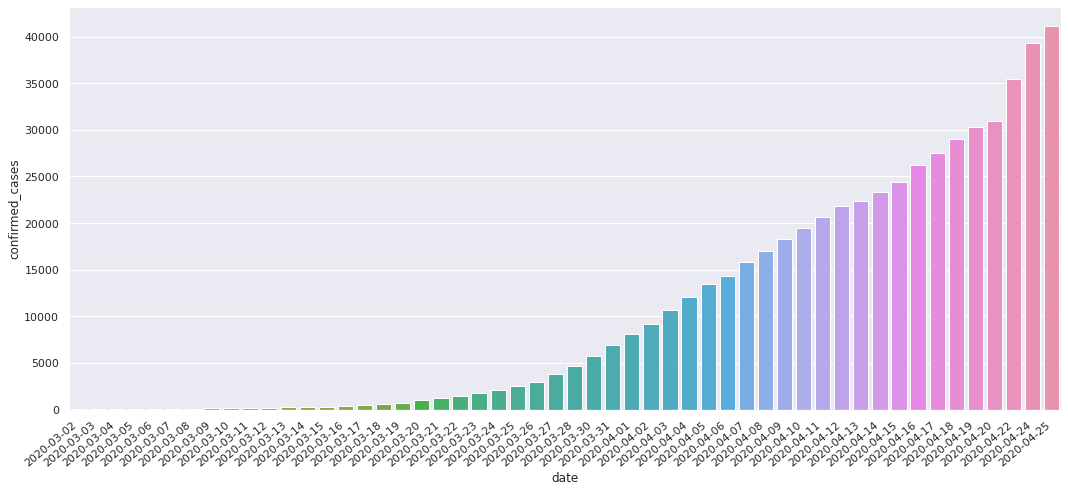

In [ ]:
# 1. Plot of Cumulative Confirmed Cases each day against Date

sns.set(rc={'figure.figsize':(15,7)})

x_dates = covid_subset['date'].dt.strftime('%Y-%m-%d').sort_values()

ax = sns.barplot(x = x_dates, y = 'confirmed_cases', data = covid_subset )
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.tight_layout()

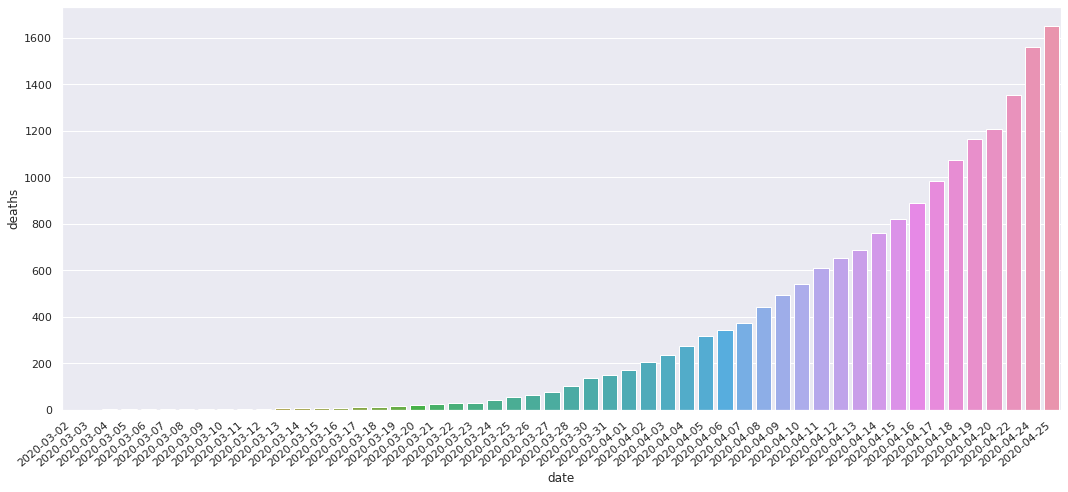

In [ ]:
# 2. Plot of Total deaths against Date

sns.set(rc={'figure.figsize':(15,7)})

x_dates = covid_subset['date'].dt.strftime('%Y-%m-%d').sort_values()

ax = sns.barplot(x = x_dates, y = 'deaths', data = covid_subset )
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.tight_layout()

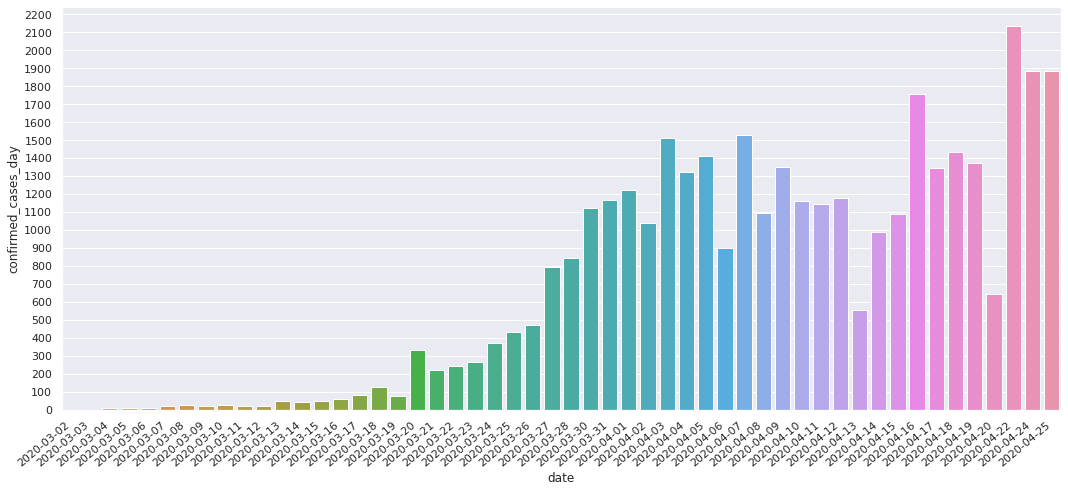

In [ ]:
# 3. Plot of New Confirmed Cases each day against Date

sns.set(rc={'figure.figsize':(15,7)})

x_dates = covid_subset['date'].dt.strftime('%Y-%m-%d').sort_values()

ax = sns.barplot(x = x_dates, y = 'confirmed_cases_day', data = covid_subset )
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

loc = plticker.MultipleLocator(base=100.0) 
ax.yaxis.set_major_locator(loc)

plt.tight_layout()

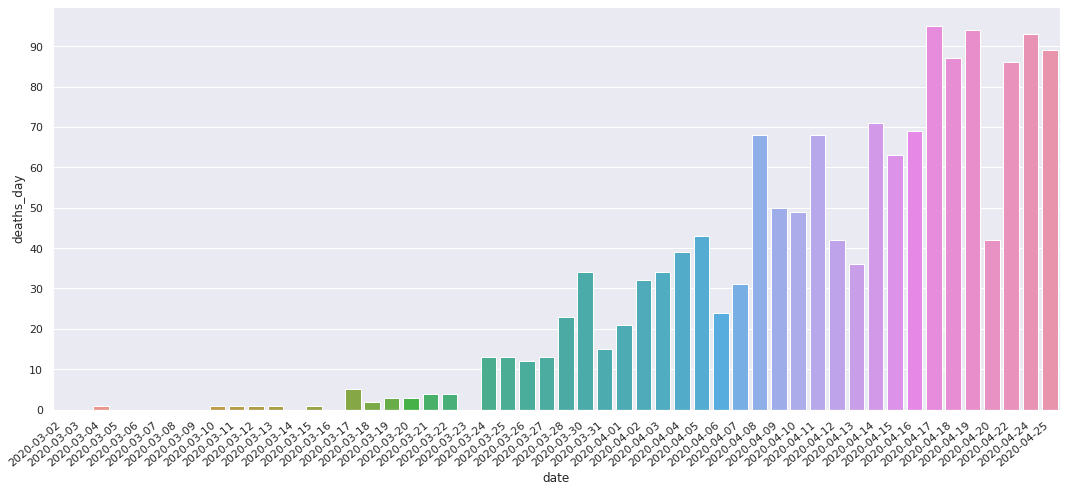

In [ ]:
# 4. Plot of New deaths against Date

sns.set(rc={'figure.figsize':(15,7)})

x_dates = covid_subset['date'].dt.strftime('%Y-%m-%d').sort_values()

ax = sns.barplot(x = x_dates, y = 'deaths_day', data = covid_subset )
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

loc = plticker.MultipleLocator(base=10.0) 
ax.yaxis.set_major_locator(loc)

plt.tight_layout()

In [ ]:
# Created air_subset df which consists of entries from start_date to end_date

air_quality['Date'] = pd.to_datetime(air_quality['Date'])
start_date2 = '2020-03-01'
end_date2 = '2020-04-25'
mask2 = (air_quality['Date'] >= start_date2) & (air_quality['Date'] <= end_date2)
air_subset = air_quality.loc[mask2]

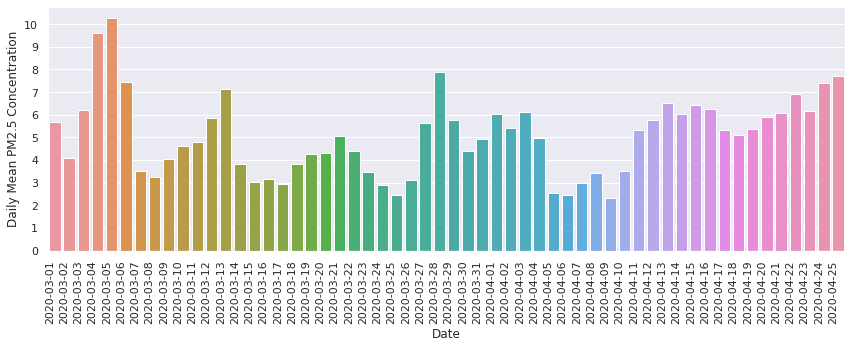

In [ ]:
sns.set(rc={'figure.figsize':(12,5)})

x_dates = air_subset['Date'].dt.strftime('%Y-%m-%d').sort_values()

ax = sns.barplot(x = x_dates, y = 'Daily Mean PM2.5 Concentration', data = air_subset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

loc = plticker.MultipleLocator(base=1.0) 
ax.yaxis.set_major_locator(loc)

plt.tight_layout()

In [ ]:
# Creating a merged dataframe for Covid + X data for purpose of plotting together in a graph

air_subset1 = air_subset.copy()
air_subset1['date'] = air_subset['Date']
covid_subset1 = covid_subset[['date', 'confirmed_cases_day','deaths_day']].copy()
merged_df = pd.merge(covid_subset1, air_subset1, on="date")
del merged_df['Date']

In [ ]:
# Normalzing the values between 0 - 20

merged_df["confirmed_cases_day"]=((merged_df["confirmed_cases_day"]-merged_df["confirmed_cases_day"].min())/(merged_df["confirmed_cases_day"].max()-merged_df["confirmed_cases_day"].min()))*20

merged_df["Daily Mean PM2.5 Concentration"]=((merged_df["Daily Mean PM2.5 Concentration"]-merged_df["Daily Mean PM2.5 Concentration"].min())/(merged_df["Daily Mean PM2.5 Concentration"].max()-merged_df["Daily Mean PM2.5 Concentration"].min()))*20

merged_df["deaths_day"]=((merged_df["deaths_day"]-merged_df["deaths_day"].min())/(merged_df["deaths_day"].max()-merged_df["deaths_day"].min()))*20

merged_df.head(5)

,date,confirmed_cases_day,deaths_day,Daily Mean PM2.5 Concentration
0,2020-04-25,17.639344,18.736842,13.618027
1,2020-04-24,17.658080,19.578947,12.839314
2,2020-04-22,20.000000,18.105263,11.540712
3,2020-04-20,6.042155,8.842105,9.063154
4,2020-04-19,12.833724,19.789474,7.730893


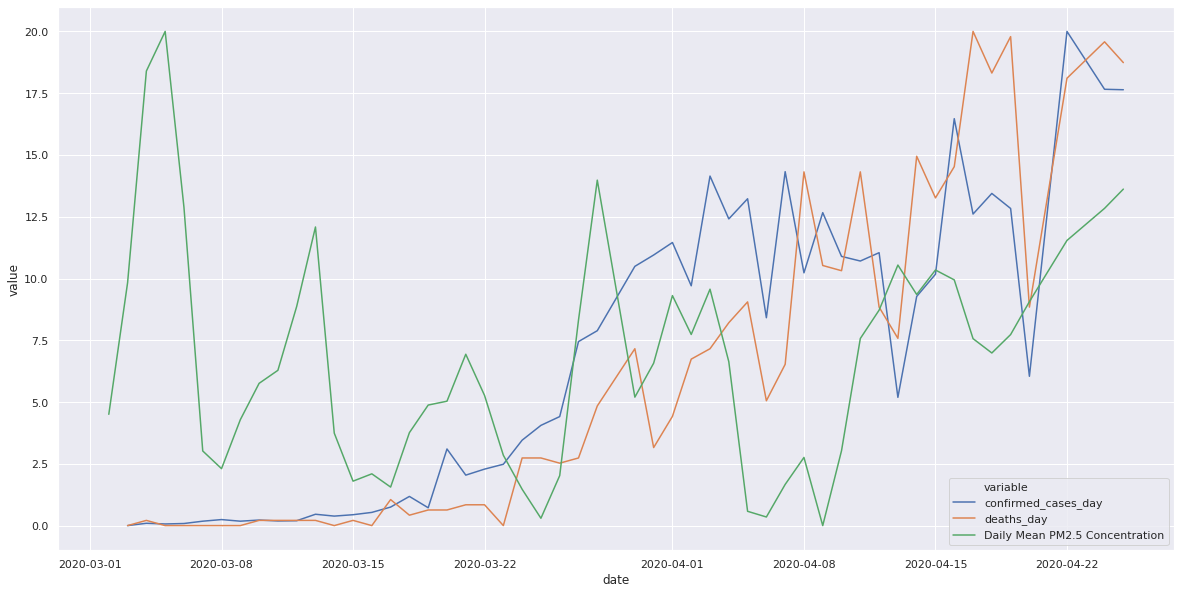

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})
sns.lineplot(x='date', y='value', hue='variable', 
             data=pd.melt(merged_df, ['date']))

## **Inferences from the graphs 1-6:**   
1. We have tried to visualize the relative variation in daily confirmed cases, deaths and Particulate matter(PM 2.5) present in air by scaling them in a value between 0-20 which seemed suitable to visualize the effects. PM2.5 are tiny particles in the air that reduce visibility and cause the air to appear hazy when levels are elevated.
2. We can see from the graphs that the Coronavirus shelter in place order has positively impacted the air-quality in California since the presence of Particulate Matter ( sometimes soot ) in air dropped to a minimum of even 2.6PM level with the highest value before shelter in place being around 10PPM. On March 19, 2020, Governor Newsom had issued the Executive Order, a statewide stay-at-home order to prevent the spread of disease. This step also implicitly meant that people commuted less and the emission from vehicles reduced, eventually impacting the Particulate matter in the atmospheric air which stayed around a lower value of 6 PPM. 
3. As for the number of the cumulative Confirmed Coronavirus cases, there had been an exponential increase with a Concave curve and for the deaths it is a convex curve, indicating the sharp rise in cases and for deaths it is a sudden rise in cases. 
4. We have tried to keep the y-axis marker at a closer distance, that will permit reading the exact values right from the graph itself.
5. We can finally infer by looking at the cumulative value graphs that the Case and death count is going to increase in the coming days. 

#**Required Inferences**

In [ ]:
last_week_df = covid_df[covid_df['date'] < pd.Timestamp(2020, 5,8)]
last_week_df = last_week_df[last_week_df['date'] > pd.Timestamp(2020, 4,28)]

second_last_week_df = covid_df[covid_df['date'] < pd.Timestamp(2020, 5,1)]
second_last_week_df = second_last_week_df[second_last_week_df['date'] >pd.Timestamp(2020, 4, 21)]

last_week_cases = np.array(last_week_df['confirmed_cases_day'])
last_week_deaths = np.array(last_week_df['deaths_day'])
second_last_week_cases = np.array(second_last_week_df['confirmed_cases_day'])
second_last_week_deaths = np.array(second_last_week_df['deaths_day'])

> ## <b> Required Inference 1 </b>

Use your COVID19 dataset to predict the COVID19 fatality and #cases for the next one week. Use the following four prediction techniques: (i) AR(3), (ii) AR(5), (iii) EWMA with alpha = 0.5, and (iv) EWMA with alpha = 0.8. Make sure that your dataset allows you to verify the one week prediction. For example, use the first three weeks of data to predict the fourth week, and report the accuracy of your predictions using the actual fourth week data. Use metrics learned in class (MAPE as a % and MSE) to report accuracy numbers.

For inference #1 - we will be using the data from March 31 to April 20 and predicting the value for April 21 

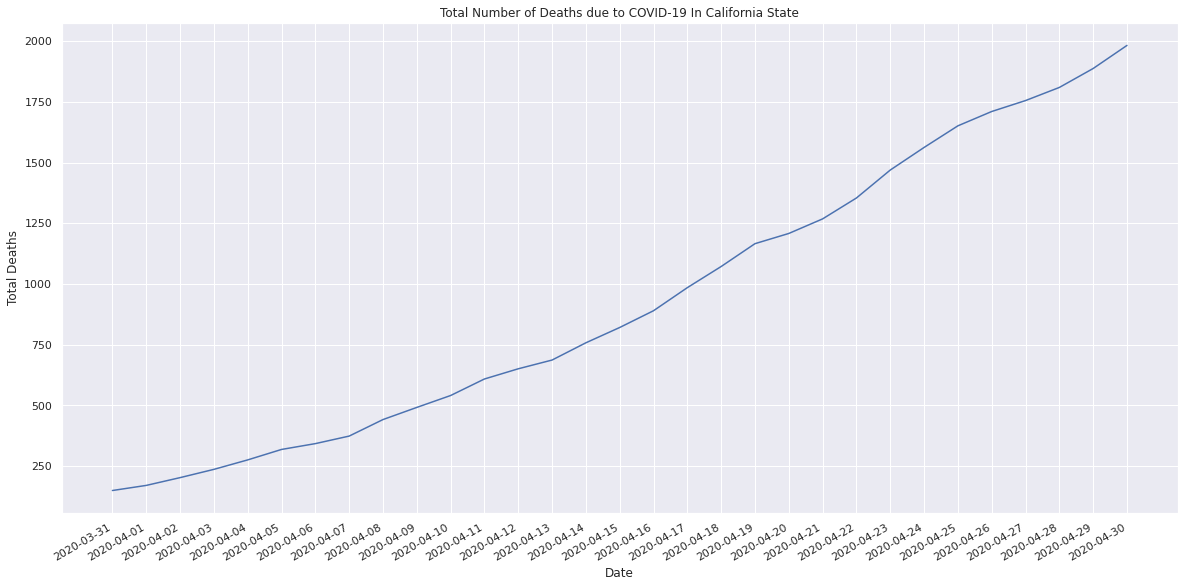

In [ ]:

covid19_dataset_uncleaned['date'] = pd.to_datetime(covid19_dataset_uncleaned['date'])
mask = (covid19_dataset_uncleaned['date'] > '2020-3-30') & (covid19_dataset_uncleaned['date'] <= '2020-4-30')
covid19_dataset_uncleaned = covid19_dataset_uncleaned.loc[mask]
#covid19_dataset_uncleaned = covid19_dataset_uncleaned.set_index(['date'])
#Plot Cases and Death Curve
plt.figure(figsize=(20,10))
plt.plot(covid19_dataset_uncleaned['date'],covid19_dataset_uncleaned['deaths'])
plt.title('Total Number of Deaths due to COVID-19 In California State')
plt.xlabel('Date') 
plt.ylabel('Total Deaths')
plt.xticks(covid19_dataset_uncleaned['date'])
plt.gcf().autofmt_xdate()
plt.show()

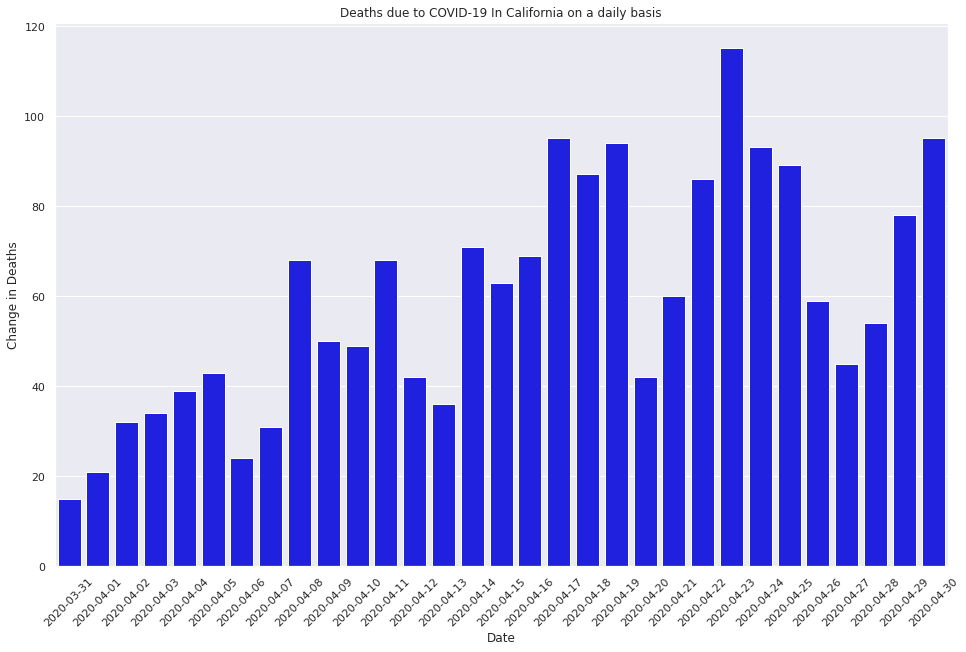

In [ ]:
data1 = pd.DataFrame()
data1['date'] = covid19_dataset_uncleaned['date'].dt.strftime('%Y-%m-%d')
data1['deaths'] = covid19_dataset_uncleaned['deaths']
data1['delta_deaths'] = covid19_dataset_uncleaned['delta_deaths']
fig_dims = (16, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('Deaths due to COVID-19 In California on a daily basis')
plot1 = sns.barplot(x='date', y='delta_deaths', data=data1, color="blue")
#plot1_1 = plot1.twinx()
#plot1_1 = sns.pointplot(y="deaths", x="date", data=data1, color="red")
plot1.set_xlabel("Date")
plot1.set_ylabel("Change in Deaths")
#plot1_1.set_ylabel("Total Deaths")
ttt = plot1.set_xticklabels(plot1.get_xticklabels(),rotation=45)

Let us define our custom code for MAPE, MSE and EWMA Calculation

In [ ]:
def mape(y_pred,y_actual):
  err = 0
  for i in range(0,len(y_actual)):
    err = err + abs(((y_actual[i] - y_pred[i])/y_actual[i])*100)
  return err/len(y_actual)

def mse(y_pred,y_actual):
  err = 0
  for i in range(0,len(y_actual)):
    err = err + (y_actual[i]-y_pred[i])*(y_actual[i]-y_pred[i])
  return err/len(y_actual)

def ewma(y_actual,alpha):
  y_pred = list()
  y_pred.append(y_actual[0])
  for i in range(1,len(y_actual)):
    val = (alpha * y_actual[i]) + ((1 - alpha)*y_pred[-1])
    y_pred.append(val)
  return y_pred

Let us predict the total number of deaths for the week from April 21 2020 to April 27 2020 using the data from March 31 2020 to April 20 2020 and calculate the statistics with the actual data

In [ ]:
mask = (covid19_dataset_uncleaned['date'] > '2020-4-20') & (covid19_dataset_uncleaned['date'] <= '2020-4-27')
covid19_dataset_uncleaned_2 = covid19_dataset_uncleaned.loc[mask]
y_actual = covid19_dataset_uncleaned_2['deaths'].values.tolist()

datestart = datetime.strptime('2020-04-20','%Y-%m-%d')
ar5_preds_data = list()

## AR(5) Implementation
for index in range(0,7):
  mask = (covid19_dataset_uncleaned['date'] > '2020-3-30') & (covid19_dataset_uncleaned['date'] <= datestart.strftime("%Y-%m-%d"))
  covid19_dataset_uncleaned_2 = covid19_dataset_uncleaned.loc[mask]
  ar5_data = pd.DataFrame()
  ar5_data['deaths'] = covid19_dataset_uncleaned_2['deaths']
  #Prepare a matrix of data to calculate the AR(5). Each row will have the data of the deaths 5 days prior to it.
  ar5_data = pd.concat([ar5_data['deaths'], ar5_data['deaths'].shift(1).rename('deaths_prior1'), ar5_data['deaths'].shift(2).rename('deaths_prior2'), ar5_data['deaths'].shift(3).rename('deaths_prior3') , ar5_data['deaths'].shift(4).rename('deaths_prior4'), ar5_data['deaths'].shift(5).rename('deaths_prior5')], axis=1)
  ar5_data = ar5_data.dropna()
  x = pd.DataFrame()
  x['deaths_prior1'] = ar5_data['deaths_prior1']
  x['deaths_prior2'] = ar5_data['deaths_prior2']
  x['deaths_prior3'] = ar5_data['deaths_prior3']
  x['deaths_prior4'] = ar5_data['deaths_prior4']
  x['deaths_prior5'] = ar5_data['deaths_prior5']
  #Add a column of 1s for ease in calculating the constant parameter using matrix multiplication
  x['def'] = 1
  x = x[['def','deaths_prior1','deaths_prior2','deaths_prior3','deaths_prior4','deaths_prior5']]
  x = x.values
  y = pd.DataFrame()
  y['deaths'] = ar5_data['deaths']
  y = y.values
  #Calculate Parameters using matrix Multiplication ((X'X)^-1)X'Y
  ar5_data = np.linalg.pinv(np.transpose(x).dot(x)).dot(np.transpose(x)).dot(y)
  y_temp = list()
  for index in range(0,y.shape[0]):
    y_temp.append(y[index][0])
  daynext = datestart
  daynext = daynext + timedelta(days=1)
  pred1 = ar5_data[0][0] + ar5_data[1][0]*y_temp[-1]+ ar5_data[2][0]*y_temp[-2] + ar5_data[3][0]*y_temp[-3] + ar5_data[4][0]*y_temp[-4] + ar5_data[5][0]*y_temp[-5]
  print("Prediction of Deaths for "+str(daynext)+" with AR(5) is : "+str(round(pred1)))
  ar5_preds_data.append(pred1)
  datestart = daynext

print('MAPE Value for AR(5) prediction : '+str(mape(ar5_preds_data,y_actual)))
print('MSE Value for AR(5) prediction : '+str(mse(ar5_preds_data,y_actual)))
print("")

## AR(3) Implementation

mask = (covid19_dataset_uncleaned['date'] > '2020-4-20') & (covid19_dataset_uncleaned['date'] <= '2020-4-27')
covid19_dataset_uncleaned_2 = covid19_dataset_uncleaned.loc[mask]
y_actual = covid19_dataset_uncleaned_2['deaths'].values.tolist()

datestart = datetime.strptime('2020-04-20','%Y-%m-%d')
ar3_preds_data = list()

for index in range(0,7):
  mask = (covid19_dataset_uncleaned['date'] > '2020-3-30') & (covid19_dataset_uncleaned['date'] <= datestart.strftime("%Y-%m-%d"))
  covid19_dataset_uncleaned_2 = covid19_dataset_uncleaned.loc[mask]
  ar5_data = pd.DataFrame()
  ar5_data['deaths'] = covid19_dataset_uncleaned_2['deaths']
  #Prepare a matrix of data to calculate the AR(3). Each row will have the data of the deaths 5 days prior to it.
  ar5_data = pd.concat([ar5_data['deaths'], ar5_data['deaths'].shift(1).rename('deaths_prior1'), ar5_data['deaths'].shift(2).rename('deaths_prior2'), ar5_data['deaths'].shift(3).rename('deaths_prior3')], axis=1)
  ar5_data = ar5_data.dropna()
  x = pd.DataFrame()
  x['deaths_prior1'] = ar5_data['deaths_prior1']
  x['deaths_prior2'] = ar5_data['deaths_prior2']
  x['deaths_prior3'] = ar5_data['deaths_prior3']
  #Add a column of 1s for ease in calculating the constant parameter using matrix multiplication
  x['def'] = 1
  x = x[['def','deaths_prior1','deaths_prior2','deaths_prior3']]
  x = x.values
  y = pd.DataFrame()
  y['deaths'] = ar5_data['deaths']
  y = y.values
  #Calculate Parameters using matrix Multiplication ((X'X)^-1)X'Y
  ar5_data = np.linalg.pinv(np.transpose(x).dot(x)).dot(np.transpose(x)).dot(y)
  y_temp = list()
  for index in range(0,y.shape[0]):
    y_temp.append(y[index][0])
  daynext = datestart
  daynext = daynext + timedelta(days=1)
  pred1 = ar5_data[0][0] + ar5_data[1][0]*y_temp[-1]+ ar5_data[2][0]*y_temp[-2] + ar5_data[3][0]*y_temp[-3]
  print("Prediction of Deaths for "+str(daynext)+" with AR(3) is : "+str(round(pred1)))
  ar3_preds_data.append(pred1)
  datestart = daynext

print('MAPE Value for AR(3) prediction : '+str(mape(ar3_preds_data,y_actual)))
print('MSE Value for AR(3) prediction : '+str(mse(ar3_preds_data,y_actual)))
print("")

mask = (covid19_dataset_uncleaned['date'] > '2020-4-20') & (covid19_dataset_uncleaned['date'] <= '2020-4-27')
covid19_dataset_uncleaned_2 = covid19_dataset_uncleaned.loc[mask]
y_actual = covid19_dataset_uncleaned_2['deaths'].values.tolist()
y_pred1 = ewma(y_actual,0.5)
y_pred2 = ewma(y_actual,0.8)
datestart = datetime.strptime('2020-04-20','%Y-%m-%d')
for i in range(0,7):
  datestart = datestart + timedelta(days = 1)
  print('Prediction of deaths for '+str(datestart)+' using EWMA(Alpha = 0.5) is '+str(round(y_pred1[i])))

print('MAPE Value for EWMA(Alpha = 0.5) prediction : '+str(mape(y_pred1,y_actual)))
print('MSE Value for EWMA(Alpha = 0.5) prediction : '+str(mse(y_pred1,y_actual)))
print("")

datestart = datetime.strptime('2020-04-20','%Y-%m-%d')
for i in range(0,7):
  datestart = datestart + timedelta(days = 1)
  print('Prediction of deaths for '+str(datestart)+' using EWMA(Alpha = 0.8) is '+str(round(y_pred2[i])))

print('MAPE Value for EWMA(Alpha = 0.8) prediction : '+str(mape(y_pred2,y_actual)))
print('MSE Value for EWMA(Alpha = 0.8) prediction : '+str(mse(y_pred2,y_actual)))

Prediction of Deaths for 2020-04-21 00:00:00 with AR(5) is : 1265.0
Prediction of Deaths for 2020-04-22 00:00:00 with AR(5) is : 1383.0
Prediction of Deaths for 2020-04-23 00:00:00 with AR(5) is : 1455.0
Prediction of Deaths for 2020-04-24 00:00:00 with AR(5) is : 1616.0
Prediction of Deaths for 2020-04-25 00:00:00 with AR(5) is : 1658.0
Prediction of Deaths for 2020-04-26 00:00:00 with AR(5) is : 1750.0
Prediction of Deaths for 2020-04-27 00:00:00 with AR(5) is : 1802.0
MAPE Value for AR(5) prediction : 1.7559695270199616
MSE Value for AR(5) prediction : 1123.7921669868351

Prediction of Deaths for 2020-04-21 00:00:00 with AR(3) is : 1298.0
Prediction of Deaths for 2020-04-22 00:00:00 with AR(3) is : 1367.0
Prediction of Deaths for 2020-04-23 00:00:00 with AR(3) is : 1448.0
Prediction of Deaths for 2020-04-24 00:00:00 with AR(3) is : 1571.0
Prediction of Deaths for 2020-04-25 00:00:00 with AR(3) is : 1652.0
Prediction of Deaths for 2020-04-26 00:00:00 with AR(3) is : 1754.0
Prediction

In [ ]:
mask = (covid19_dataset_uncleaned['date'] > '2020-4-20') & (covid19_dataset_uncleaned['date'] <= '2020-4-27')
covid19_dataset_uncleaned_2 = covid19_dataset_uncleaned.loc[mask]
y_actual = covid19_dataset_uncleaned_2['confirmed_cases'].values.tolist()

datestart = datetime.strptime('2020-04-20','%Y-%m-%d')
ar5_preds_data = list()

for index in range(0,7):
  mask = (covid19_dataset_uncleaned['date'] > '2020-3-30') & (covid19_dataset_uncleaned['date'] <= datestart.strftime("%Y-%m-%d"))
  covid19_dataset_uncleaned_2 = covid19_dataset_uncleaned.loc[mask]
  ar5_data = pd.DataFrame()
  ar5_data['confirmed_cases'] = covid19_dataset_uncleaned_2['confirmed_cases']
  ar5_data = pd.concat([ar5_data['confirmed_cases'], ar5_data['confirmed_cases'].shift(1).rename('confirmed_cases_prior1'), ar5_data['confirmed_cases'].shift(2).rename('confirmed_cases_prior2'), ar5_data['confirmed_cases'].shift(3).rename('confirmed_cases_prior3') , ar5_data['confirmed_cases'].shift(4).rename('confirmed_cases_prior4'), ar5_data['confirmed_cases'].shift(5).rename('confirmed_cases_prior5')], axis=1)
  ar5_data = ar5_data.dropna()
  x = pd.DataFrame()
  x['confirmed_cases_prior1'] = ar5_data['confirmed_cases_prior1']
  x['confirmed_cases_prior2'] = ar5_data['confirmed_cases_prior2']
  x['confirmed_cases_prior3'] = ar5_data['confirmed_cases_prior3']
  x['confirmed_cases_prior4'] = ar5_data['confirmed_cases_prior4']
  x['confirmed_cases_prior5'] = ar5_data['confirmed_cases_prior5']
  x['def'] = 1
  x = x[['def','confirmed_cases_prior1','confirmed_cases_prior2','confirmed_cases_prior3','confirmed_cases_prior4','confirmed_cases_prior5']]
  x = x.values
  y = pd.DataFrame()
  y['confirmed_cases'] = ar5_data['confirmed_cases']
  y = y.values
  ar5_data = np.linalg.pinv(np.transpose(x).dot(x)).dot(np.transpose(x)).dot(y)
  y_temp = list()
  for index in range(0,y.shape[0]):
    y_temp.append(y[index][0])
  daynext = datestart
  daynext = daynext + timedelta(days=1)
  pred1 = ar5_data[0][0] + ar5_data[1][0]*y_temp[-1]+ ar5_data[2][0]*y_temp[-2] + ar5_data[3][0]*y_temp[-3] + ar5_data[4][0]*y_temp[-4] + ar5_data[5][0]*y_temp[-5]
  print("Prediction of Confirmed Cases for "+str(daynext)+" with AR(5) is : "+str(round(pred1)))
  ar5_preds_data.append(pred1)
  datestart = daynext

print('MAPE Value for AR(5) prediction : '+str(mape(ar5_preds_data,y_actual)))
print('MSE Value for AR(5) prediction : '+str(mse(ar5_preds_data,y_actual)))
print("")


mask = (covid19_dataset_uncleaned['date'] > '2020-4-20') & (covid19_dataset_uncleaned['date'] <= '2020-4-27')
covid19_dataset_uncleaned_2 = covid19_dataset_uncleaned.loc[mask]
y_actual = covid19_dataset_uncleaned_2['confirmed_cases'].values.tolist()

datestart = datetime.strptime('2020-04-20','%Y-%m-%d')
ar5_preds_data = list()

for index in range(0,7):
  mask = (covid19_dataset_uncleaned['date'] > '2020-3-30') & (covid19_dataset_uncleaned['date'] <= datestart.strftime("%Y-%m-%d"))
  covid19_dataset_uncleaned_2 = covid19_dataset_uncleaned.loc[mask]
  ar5_data = pd.DataFrame()
  ar5_data['confirmed_cases'] = covid19_dataset_uncleaned_2['confirmed_cases']
  ar5_data = pd.concat([ar5_data['confirmed_cases'], ar5_data['confirmed_cases'].shift(1).rename('confirmed_cases_prior1'), ar5_data['confirmed_cases'].shift(2).rename('confirmed_cases_prior2'), ar5_data['confirmed_cases'].shift(3).rename('confirmed_cases_prior3')], axis=1)
  ar5_data = ar5_data.dropna()
  x = pd.DataFrame()
  x['confirmed_cases_prior1'] = ar5_data['confirmed_cases_prior1']
  x['confirmed_cases_prior2'] = ar5_data['confirmed_cases_prior2']
  x['confirmed_cases_prior3'] = ar5_data['confirmed_cases_prior3']
  x['def'] = 1
  x = x[['def','confirmed_cases_prior1','confirmed_cases_prior2','confirmed_cases_prior3']]
  x = x.values
  y = pd.DataFrame()
  y['confirmed_cases'] = ar5_data['confirmed_cases']
  y = y.values
  ar5_data = np.linalg.pinv(np.transpose(x).dot(x)).dot(np.transpose(x)).dot(y)
  y_temp = list()
  for index in range(0,y.shape[0]):
    y_temp.append(y[index][0])
  daynext = datestart
  daynext = daynext + timedelta(days=1)
  pred1 = ar5_data[0][0] + ar5_data[1][0]*y_temp[-1]+ ar5_data[2][0]*y_temp[-2] + ar5_data[3][0]*y_temp[-3]
  print("Prediction of Confirmed Cases for "+str(daynext)+" with AR(3) is : "+str(round(pred1)))
  ar5_preds_data.append(pred1)
  datestart = daynext

print('MAPE Value for AR(3) prediction : '+str(mape(ar5_preds_data,y_actual)))
print('MSE Value for AR(3) prediction : '+str(mse(ar5_preds_data,y_actual)))
print("")

mask = (covid19_dataset_uncleaned['date'] > '2020-4-20') & (covid19_dataset_uncleaned['date'] <= '2020-4-27')
covid19_dataset_uncleaned_2 = covid19_dataset_uncleaned.loc[mask]
y_actual = covid19_dataset_uncleaned_2['confirmed_cases'].values.tolist()
y_pred1 = ewma(y_actual,0.5)
y_pred2 = ewma(y_actual,0.8)
datestart = datetime.strptime('2020-04-20','%Y-%m-%d')
for i in range(0,7):
  datestart = datestart + timedelta(days = 1)
  print('Prediction of Confirmed Cases for '+str(datestart)+' using EWMA(Alpha = 0.5) is '+str(round(y_pred1[i])))

print('MAPE Value for EWMA(Alpha = 0.5) prediction : '+str(mape(y_pred1,y_actual)))
print('MSE Value for EWMA(Alpha = 0.5) prediction : '+str(mse(y_pred1,y_actual)))
print("")

datestart = datetime.strptime('2020-04-20','%Y-%m-%d')
for i in range(0,7):
  datestart = datestart + timedelta(days = 1)
  print('Prediction of Confirmed Cases for '+str(datestart)+' using EWMA(Alpha = 0.8) is '+str(round(y_pred2[i])))

print('MAPE Value for EWMA(Alpha = 0.8) prediction : '+str(mape(y_pred2,y_actual)))
print('MSE Value for EWMA(Alpha = 0.8) prediction : '+str(mse(y_pred2,y_actual)))

Prediction of Confirmed Cases for 2020-04-21 00:00:00 with AR(5) is : 32010.0
Prediction of Confirmed Cases for 2020-04-22 00:00:00 with AR(5) is : 33632.0
Prediction of Confirmed Cases for 2020-04-23 00:00:00 with AR(5) is : 37184.0
Prediction of Confirmed Cases for 2020-04-24 00:00:00 with AR(5) is : 38967.0
Prediction of Confirmed Cases for 2020-04-25 00:00:00 with AR(5) is : 40932.0
Prediction of Confirmed Cases for 2020-04-26 00:00:00 with AR(5) is : 43015.0
Prediction of Confirmed Cases for 2020-04-27 00:00:00 with AR(5) is : 43767.0
MAPE Value for AR(5) prediction : 1.8830994701734143
MSE Value for AR(5) prediction : 806916.5385355053

Prediction of Confirmed Cases for 2020-04-21 00:00:00 with AR(3) is : 32099.0
Prediction of Confirmed Cases for 2020-04-22 00:00:00 with AR(3) is : 34022.0
Prediction of Confirmed Cases for 2020-04-23 00:00:00 with AR(3) is : 36889.0
Prediction of Confirmed Cases for 2020-04-24 00:00:00 with AR(3) is : 39160.0
Prediction of Confirmed Cases for 202

> ## <b> Required Inference 2 </b>

In [ ]:
last_w = last_week_df
sec_last_w = second_last_week_df

In [ ]:
############# MEAN VALUES OF LAST AND SECOND LAST WEEK ######################
# CASES

week1_cases_mean = sec_last_w['confirmed_cases_day'].mean()
week2_cases_mean = last_w['confirmed_cases_day'].mean()
print("CONFIRMED CASES")
print("Mean of COVID19 cases in second last week:", week1_cases_mean)
print("Mean of COVID19 cases in  last week:", week2_cases_mean)


# DEATHS
week1_death_mean = sec_last_w['deaths_day'].mean()
week2_death_mean = last_w['deaths_day'].mean()
print("DEATHS")
print("Mean of COVID19 deaths in second last week:", week1_death_mean)
print("Mean of COVID19 deaths in  last week:", week2_death_mean)

CONFIRMED CASES
Mean of COVID19 cases in second last week: 1609.4285714285713
Mean of COVID19 cases in  last week: 1509.0
DEATHS
Mean of COVID19 deaths in second last week: 72.0
Mean of COVID19 deaths in  last week: 72.14285714285714


**1. Walds Test**

In [ ]:
# Wald's One sample test

def mean_mle(values):
  return values.mean()

def variance_mle(values):
  return values.var()

def mean_difference(x,true_value):
  return mean_mle(x) - true_value

def variance(x,y):
  return variance_mle(x)/x.size + variance_mle(y)/y.size

def std_err(x):
  return math.sqrt(mean_mle(x)/ len(x))

def walds_value_one(x, true_value):
  return (mean_difference(x,true_value)/std_err(x))

#True value is the mean of second last week data
def walds_test_one(x,y,z_alpha_by_2 = 1.962):
  return abs(walds_value_one(x,y.mean())) < z_alpha_by_2
print("CONFIRMED CASES")
print('The confirmed_cases means are same? Walds test says - '+str(walds_test_one(last_w['confirmed_cases_day'], sec_last_w['confirmed_cases_day'])))
print('Wald\'s value = '+str(walds_value_one(last_w['confirmed_cases_day'], sec_last_w['confirmed_cases_day'].mean())))
print("DEATHS")
print('The death means are same? Walds test says - '+str(walds_test_one(last_w['deaths_day'], sec_last_w['deaths_day'])))
print('Wald\'s value = '+str(walds_value_one(last_w['deaths_day'], sec_last_w['deaths_day'].mean())))

CONFIRMED CASES
The confirmed_cases means are same? Walds test says - False
Wald's value = -6.840087937415298
DEATHS
The death means are same? Walds test says - True
Wald's value = 0.044499415948997215


In [ ]:
# Wald's Two Sample Test

def std_err_delta(x, y):
  dif = np.array(x) - np.array(y)
  # print(dif)
  # print(dif.var())
  return dif.var()

def mean_diff_2_sample(x,y):
  return x.mean()- y.mean()

def walds_value_two(x,y):
  return (mean_diff_2_sample(x,y)/std_err_delta(x,y))

def walds_test_two_sample(x,y,z_alpha_by_2 = 1.962):
  return abs(walds_value_two(x,y)) < z_alpha_by_2


print("CONFIRMED CASES")
print('The confirmed_cases means are same? Walds test says - '+str(walds_test_two_sample(last_w['confirmed_cases_day'], sec_last_w['confirmed_cases_day'])))
print('Wald\'s value = '+str(walds_value_two(last_w['confirmed_cases_day'], sec_last_w['confirmed_cases_day'])))
print("DEATHS")
print('The death means are same? Walds test says - '+str(walds_test_two_sample(last_w['deaths_day'], sec_last_w['deaths_day'])))
print('Wald\'s value = '+str(walds_value_two(last_w['deaths_day'], sec_last_w['deaths_day'])))

CONFIRMED CASES
The confirmed_cases means are same? Walds test says - True
Wald's value = -0.0008106477703315098
DEATHS
The death means are same? Walds test says - True
Wald's value = 0.001455906821963353


**Applicability of Wald's-test:** For Wald's test we are assuming that the data is Poisson distributed and as we are using the MLE estimate for it which is an Asymptotically Normal estimate, therefore the test is applicable.

**2. Z-test**


In [ ]:
def std_dev(value):
  tot = np.sum((value-value.mean())**2)
  return math.sqrt((tot/len(value)))

def z_value(last_w, secondlast_w, entire_data):
  return (last_w.mean() - secondlast_w.mean())/(std_dev(entire_data)/math.sqrt(len(last_w)))

def z_test(x, y, full, z_alpha_by_2 = 1.962):
  return  abs(z_value(x,y, full)) < z_alpha_by_2

print("CONFIRMED CASES")
print('Are the Confirmed_cases means are same? Z-test says - '+str(z_test(last_w['confirmed_cases_day'], sec_last_w['confirmed_cases_day'], covid_df['confirmed_cases_day']))+'. Z-value = '+str(z_value(last_w['confirmed_cases_day'], sec_last_w['confirmed_cases_day'], covid_df['confirmed_cases_day'])))
print("DEATHS")
print('Are the Death means same? Z-test says - '+str(z_test(last_w['deaths_day'], sec_last_w['deaths_day'], covid_df['deaths_day']))+'. Z-value = '+str(z_value(last_w['deaths_day'], sec_last_w['deaths_day'], covid_df['deaths_day'])))


CONFIRMED CASES
Are the Confirmed_cases means are same? Z-test says - True. Z-value = -0.3979793894273812
DEATHS
Are the Death means same? Z-test says - True. Z-value = 0.011448691225299427


**Applicability of Z-test:** The assumption of Z-test requires that we know the true Standard Deviation of the data but in our case we use the sample standard deviation of the entire covid19 dataset as true SD.   
Also, Z-test is applicable when size of our dataset is very large, but in our case the data size is just 7 and also that data itself is not normally distributed so, it can be said that Z-test is not applicable in this case.

**3. T-Test**

In [ ]:
# 1-SAMPLE T-test
def std_dev(value):
  tot = np.sum((value-value.mean())**2)
  return math.sqrt((tot/len(value)))

def t_test_1_sample_value(x, y):
  return (x.mean()-y.mean())/(std_dev(y)/math.sqrt(len(x)))

def t_test_1_sample(x, y, threshold = 2.447):
  return abs(t_test_1_sample_value(x,y)) < threshold

# Cases
print("CONFIRMED CASES")
print('The Confirmed cases means are same? One-sample T-test says - ', str(t_test_1_sample(last_w['confirmed_cases_day'],sec_last_w['confirmed_cases_day'])))
print('One-sample T-test value = ', str( t_test_1_sample_value(last_w['confirmed_cases_day'],sec_last_w['confirmed_cases_day'])))
# Deaths
print("DEATHS")
print('The Confirmed cases means are same? One-sample T-test says - ', str(t_test_1_sample(last_w['deaths_day'],sec_last_w['deaths_day'])))
print('One-sample T-test value = ', str( t_test_1_sample_value(last_w['deaths_day'],sec_last_w['deaths_day'])))

CONFIRMED CASES
The Confirmed cases means are same? One-sample T-test says -  True
One-sample T-test value =  -0.7479164776514292
DEATHS
The Confirmed cases means are same? One-sample T-test says -  True
One-sample T-test value =  0.021398024625545034


In [ ]:
# 2-SAMPLE T-test
# Paired T-test

def pairwise_difference(x,y):
  return np.array(x)-np.array(y)

def paired_t_test_value(x, y):
  dif = pairwise_difference(x,y)
  return (dif.mean()*math.pow(dif.size,0.5)/math.pow(variance_mle(dif),0.5))

def paired_t_test(x,y,threshold = 2.447):
  return abs(paired_t_test_value(x,y)) < threshold

print("CONFIRMED CASES")
print('The population means are same? Paired T Test says - ', str(paired_t_test(last_w['confirmed_cases_day'],sec_last_w['confirmed_cases_day'])))
print('Paired T-test value = ', str( paired_t_test_value(last_w['confirmed_cases_day'],sec_last_w['confirmed_cases_day'])))


# Unpaired T-test

def std_dev_pair(x, y): #unpaired
  return math.sqrt((variance_mle(x)/x.size) + (variance_mle(y)/y.size))

def unpaired_t_test_value(x,y): # new 
  dif = x.mean() - y.mean()
  return dif/std_dev_pair(x,y)

def unpaired_t_test(x,y, threshold = 2.447):
  return abs(paired_t_test_value(x,y)) < threshold


print('The population means are same? Unpaired T Test says - '+str(unpaired_t_test(last_w['confirmed_cases_day'],sec_last_w['confirmed_cases_day'])))
print('Unpaired T Test\'s value = '+str(unpaired_t_test_value(last_w['confirmed_cases_day'],sec_last_w['confirmed_cases_day'])))

print("DEATHS")
print('The population means are same? Paired T Test says - ', str(paired_t_test(last_w['deaths_day'],sec_last_w['deaths_day'])))
print('Paired T-test value = ', str( paired_t_test_value(last_w['deaths_day'],sec_last_w['deaths_day'])))
print('The population means are same? Unpaired T Test says - '+str(unpaired_t_test(last_w['deaths_day'],sec_last_w['deaths_day'])))
print('Unpaired T Test\'s value = '+str(unpaired_t_test_value(last_w['deaths_day'],sec_last_w['deaths_day'])))


CONFIRMED CASES
The population means are same? Paired T Test says -  True
Paired T-test value =  -0.7549075324455652
The population means are same? Unpaired T Test says - True
Unpaired T Test's value = -0.6127666161904948
DEATHS
The population means are same? Paired T Test says -  True
Paired T-test value =  0.03815634707310691
The population means are same? Unpaired T Test says - True
Unpaired T Test's value = 0.012359815830228056


**Applicability of T-test:** As the dataset size which we are considering is small T-test is most applicable in our cases and also it does not require that the true standard deviation of the data be known to us.   
Also, it does not require that the underlying distribution of Data is normal.
So we can say T-test is applicable in this case.  
However, the paired T-test is not applicable since it required the two populations to be dependent on each other, but in our case the last week's death and cases data is not dependent upon the previous week’s count, therefore Paired t-test will not be applicable.


> ## <b>Required Inference 3 </b>

In [ ]:
def get_x_cdf(data):
  cdf = []
  checked = []
  final_map = {}
  for i in range(0, len(data)):
    if(data[i] not in checked):
      checked.append(data[i])
      left_count = 0
      right_count = 0
      for j in range(0, len(data)):
        if(data[i] >= data[j]):
          right_count = right_count+1
        if(data[i]> data[j]):
          left_count = left_count+1
      left_count = left_count / len(data)
      right_count = right_count / len(data)
      temp_map = {
        'left_cdf': left_count,
        'right_cdf': right_count }
      
      final_map[data[i]] = temp_map
  return final_map

In [ ]:
#Binomial
from scipy.stats import binom
def get_binomial_mme(data):
  p_hat = 1 - (np.var(data) / np.mean(data))
  m_hat = math.pow(np.mean(data), 2) / (np.mean(data) - np.var(data))
  m_hat = np.mean(data) / p_hat
  return p_hat, m_hat

def run_1_sample_ks_binom(last_week_stats, second_last_week_stats):
  last_week_stats.sort()
  second_last_week_stats.sort()
  p_mme, m_mme = get_binomial_mme(second_last_week_stats)
  x_cdf = get_x_cdf(second_last_week_stats)
  max_val = -1
  for i in range(0, len(second_last_week_stats)):
    left_cdf =  x_cdf[second_last_week_stats[i]]['left_cdf']
    right_cdf = x_cdf[second_last_week_stats[i]]['right_cdf']
    bin_cdf = binom.cdf(last_week_stats[i], m_mme, p_mme)
    left_diff = abs(left_cdf - bin_cdf)
    right_diff = abs(right_cdf - bin_cdf)
    max_val = max(max_val, max(left_diff, right_diff))
  return max_val

val_cases = run_1_sample_ks_binom(last_week_cases, second_last_week_cases)
val_deaths = run_1_sample_ks_binom(last_week_deaths, second_last_week_deaths)
print('KS Test - Cases vs Binomial', val_cases)
print('Since the statistic value > 0.05, we reject the hypothesis that number of cases follow Binomial')
print('KS Test - Deaths vs Binomial', val_deaths)
print('Since the statistic value > 0.05, we reject the hypothesis that number of deahts follow Binomial')

KS Test - Cases vs Binomial 1.0
Since the statistic value > 0.05, we reject the hypothesis that number of cases follow Binomial
KS Test - Deaths vs Binomial 1.0
Since the statistic value > 0.05, we reject the hypothesis that number of deahts follow Binomial


In [ ]:
#Poisson
from scipy.stats import poisson
def get_poisson_mme(data):
  lambda_hat = np.mean(data)
  return lambda_hat


def run_1_sample_ks_poisson(last_week_stats, second_last_week_stats):
  last_week_stats.sort()
  second_last_week_stats.sort()
  lambda_hat = get_poisson_mme(second_last_week_stats)
  x_cdf = get_x_cdf(second_last_week_stats)
  max_val = -1
  for i in range(0, len(second_last_week_stats)):
    left_cdf =  x_cdf[second_last_week_stats[i]]['left_cdf']
    right_cdf = x_cdf[second_last_week_stats[i]]['right_cdf']
    poisson_cdf = poisson.cdf(last_week_stats[i],lambda_hat)
    left_diff = abs(left_cdf - poisson_cdf)
    right_diff = abs(right_cdf - poisson_cdf)
    max_val = max(max_val, max(left_diff, right_diff))
  return max_val

val_cases = run_1_sample_ks_poisson(last_week_cases, second_last_week_cases)
val_deaths = run_1_sample_ks_poisson(last_week_deaths, second_last_week_deaths)
print('KS Test - Cases vs Poisson', val_cases)
print('Since the statistic value > 0.05, we reject the hypothesis that number of cases follow Poisson')
print('KS Test - Deaths vs Poisson', val_deaths)
print('Since the statistic value > 0.05, we reject the hypothesis that number of deaths follow Poisson')

KS Test - Cases vs Poisson 0.696703385102116
Since the statistic value > 0.05, we reject the hypothesis that number of cases follow Poisson
KS Test - Deaths vs Poisson 0.415478393633258
Since the statistic value > 0.05, we reject the hypothesis that number of deaths follow Poisson


In [ ]:
#Geometric
from scipy.stats import geom
def get_geometric_mme(data):
  p_hat = 1/np.mean(data)
  return p_hat


def run_1_sample_ks_geometric(last_week_stats, second_last_week_stats):
  last_week_stats.sort()
  second_last_week_stats.sort()
  p_hat = get_geometric_mme(second_last_week_stats)
  x_cdf = get_x_cdf(second_last_week_stats)
  max_val = -1
  for i in range(0, len(second_last_week_stats)):
    left_cdf =  x_cdf[second_last_week_stats[i]]['left_cdf']
    right_cdf = x_cdf[second_last_week_stats[i]]['right_cdf']
    geom_cdf = geom.cdf(last_week_stats[i],p_hat)
    left_diff = abs(left_cdf - geom_cdf)
    right_diff = abs(right_cdf - geom_cdf)
    max_val = max(max_val, max(left_diff, right_diff))
  return max_val

val_cases = run_1_sample_ks_geometric(last_week_cases, second_last_week_cases)
val_deaths = run_1_sample_ks_geometric(last_week_deaths, second_last_week_deaths)
print('KS Test - Cases vs Geometric', val_cases)
print('Since the statistic value > 0.05, we reject the hypothesis that number of cases follow Geometric')
print('KS Test - Deaths vs Geometric', val_deaths)
print('Since the statistic value > 0.05, we reject the hypothesis that number of deaths follow Geometric')

KS Test - Cases vs Geometric 0.5472670563470299
Since the statistic value > 0.05, we reject the hypothesis that number of cases follow Geometric
KS Test - Deaths vs Geometric 0.42042687454750016
Since the statistic value > 0.05, we reject the hypothesis that number of deaths follow Geometric


In [ ]:
# 2 Sample KS test
def get_cdf_value_y(sample, data_y):
  count = 0
  for i in range(0, len(data_y)):
    if(data_y[i] <= sample):
      count= count+1
  return count / len(data_y)
def run_2_sample_ks_test(data_x, data_y):
  data_x.sort()
  data_y.sort()
  x_cdf = get_x_cdf(data_x)
  max_val = -1
  for i in range(0, len(data_x)):
    x_left = x_cdf[data_x[i]]['left_cdf']
    x_right = x_cdf[data_x[i]]['right_cdf']
    y = get_cdf_value_y(data_x[i], data_y)
    max_val = max(max_val, max(abs(x_left - y), abs(x_right-y)))
  return max_val

max_value = run_2_sample_ks_test(second_last_week_cases, last_week_cases)
print('KS Test - Last week cases vs Second last week cases', max_value)
print('Since the statistic value > 0.05, we reject the hypothesis that number of cases for 2 weeks are from same distribution')
max_value = run_2_sample_ks_test(second_last_week_deaths, last_week_deaths)
print('KS Test - Last week deaths vs Second last week deaths', max_value)
print('Since the statistic value > 0.05, we reject the hypothesis that number of deaths for 2 weeks are from same distribution')

KS Test - Last week cases vs Second last week cases 0.4285714285714286
Since the statistic value > 0.05, we reject the hypothesis that number of cases for 2 weeks are from same distribution
KS Test - Last week deaths vs Second last week deaths 0.2857142857142857
Since the statistic value > 0.05, we reject the hypothesis that number of deaths for 2 weeks are from same distribution


In [ ]:
#Permutation test

#Instead of generating all 14! factorial permutations, 
# We are shuffling the array randomly and generating 50,000 unique permutations to run the permutation test

def generate_permutations(data, max_count, all_permutations):
    count = 0
    while(count < max_count):
      random.shuffle(data)
      if ~(data in all_permutations):
             all_permutations.append(data[:])
             count = count+1
    return all_permutations

def run_permutation_test(data_last_week, data_second_last):
  t_obs = abs(np.mean(data_last_week) - np.mean(data_second_last))
  combined_data = []
  for i in range(0,len(data_last_week)):
    combined_data.append(data_last_week[i])
    combined_data.append(data_second_last[i])
  all_permutations = []
  all_permutations.append(combined_data)
  all_permutations = generate_permutations(combined_data, 50000,all_permutations)
  greater_count = 0

  for i in range(0,len(all_permutations)):
    permutation = all_permutations[i]
    data_x = permutation[0: math.floor(len(permutation)/2)]
    data_y = permutation[math.floor(len(permutation)/2): len(permutation)]
    
    t_i = abs(np.mean(data_x) - np.mean(data_y))    
    if(t_i > t_obs):
      greater_count = greater_count + 1
  p_value = greater_count / len(all_permutations)
  return p_value

p_value = run_permutation_test(last_week_cases, second_last_week_cases)
print('Permutation Test Last week cases vs second last week cases, p-value =', p_value, '\nWe fail to reject the Hypothesis, the 2 datasets are from the same distribution')
p_value = run_permutation_test(last_week_deaths, second_last_week_deaths)
print('Permutation Test Last week deaths vs second last week deaths, p-value =', p_value , '\n We fail to reject the Hypothesis, the 2 datasets are from the same distribution')

Permutation Test Last week cases vs second last week cases, p-value = 0.5484090318193636 
We fail to reject the Hypothesis, the 2 datasets are from the same distribution
Permutation Test Last week deaths vs second last week deaths, p-value = 0.9813803723925522 
 We fail to reject the Hypothesis, the 2 datasets are from the same distribution


>## <b>Required Inference 4 </b>

In [ ]:
# Cells for > Required Inference 4
def calc_mean(val_list):
    return sum(val_list)/len(val_list)


def calc_product_mean(val1_list, val2_list):
    prod_list = [x * y for x, y in zip(val1_list, val2_list)]
    return sum(prod_list)/len(prod_list)


def standard_deviation(val_list):
    sum_sqr_mean = calc_mean([x*x for x in val_list])
    val_avg = calc_mean(val_list)
    return math.sqrt(sum_sqr_mean - val_avg**2)


def calculate_pearson(val1_list, val2_list):
    std_x = standard_deviation(val1_list)
    std_y = standard_deviation(val2_list)

    prod_mean = calc_product_mean(val1_list, val2_list)
    mean_x = calc_mean(val1_list)
    mean_y = calc_mean(val2_list)
    
    covariance = prod_mean - mean_x * mean_y
    return covariance / (std_x * std_y)

In [ ]:
calculate_pearson(air_quality_df['Daily Mean PM2.5 Concentration'].tolist()[:-1], covid_df['deaths_day'].tolist()[:-1])

-0.1576041251281626

In [ ]:
calculate_pearson(air_quality_df['Daily Mean PM2.5 Concentration'].tolist()[:-1], covid_df['confirmed_cases_day'].tolist()[:-1])

-0.19049101885542438

Taking Pearson correlation of the PM2.5 concentration in the California's Air with Daily Deaths and Daily Cases, shows a negative correlation. Thus, as the number of cases and deaths increased the air quality of California increased (as the PM2.5 concentration decreased). This is a side-effect of the lockdown that was imposed which caused the air quality to increase.

> ## <b>Required Inference 5</b>

In [ ]:
def get_weekly_deaths_data(df, week_from, week_to):
  week_df = df[df['date'] > week_from]
  week_df = week_df[week_df['date'] < week_to]
  week_deaths = np.array(week_df['deaths_day'])
  return week_deaths

In [ ]:
week_1 = get_weekly_deaths_data(covid_df, pd.Timestamp(2020, 4,9), pd.Timestamp(2020, 4,17))
week_2 = get_weekly_deaths_data(covid_df, pd.Timestamp(2020, 4,16), pd.Timestamp(2020, 4,24))
week_3 = get_weekly_deaths_data(covid_df, pd.Timestamp(2020, 4,23), pd.Timestamp(2020, 5,1))
week_4 = get_weekly_deaths_data(covid_df, pd.Timestamp(2020, 4,30), pd.Timestamp(2020, 5,8))
week_2 = np.append(week_2, week_1)
week_3 = np.append(week_3, week_2)
week_4 = np.append(week_4, week_3)

In [ ]:
def get_post_alpha_beta(data):
  alpha = np.sum(data) +1
  beta = len(data) + 1 / np.mean(data)
  return alpha, beta
def get_map(data):
  lambda_map = ((np.sum(data)) / (len(data) + 1/np.mean(data)))
  return lambda_map

alpha_week1, beta_week1 = get_post_alpha_beta(week_1)
alpha_week2, beta_week2 = get_post_alpha_beta(week_2)
alpha_week3, beta_week3 = get_post_alpha_beta(week_3)
alpha_week4, beta_week4 = get_post_alpha_beta(week_4)

map_1 = get_map(week_1)
map_2 = get_map(week_2)
map_3 = get_map(week_3)
map_4 = get_map(week_4)


print('MAP after week 1:' , map_1)
print('MAP after week 2:' , map_2)
print('MAP after week 3:' , map_3)
print('MAP after week 4:' , map_4)

MAP after week 1: 56.71464375223774
MAP after week 2: 66.75010377750104
MAP after week 3: 67.72226772226773
MAP after week 4: 68.58335861650485


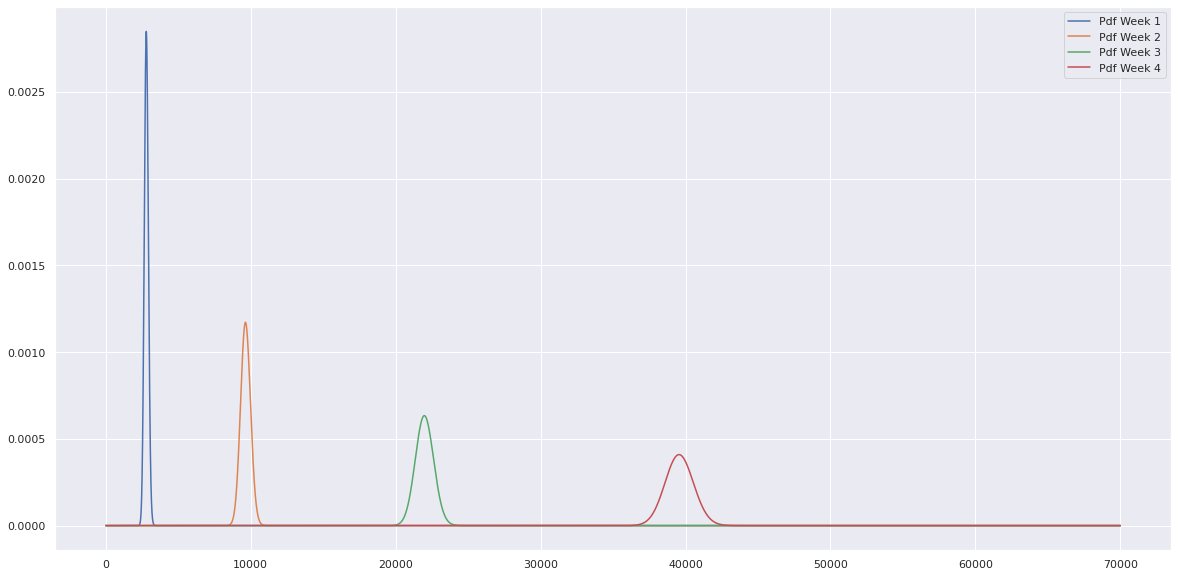

In [ ]:
from scipy.stats import gamma
x = np.linspace(0, 70000, 70000)
rv_1 = gamma.pdf(x, alpha_week1, scale = beta_week1)
rv_2 = gamma.pdf(x, alpha_week2, scale = beta_week2)
rv_3 = gamma.pdf(x, alpha_week3, scale = beta_week3)
rv_4 = gamma.pdf(x, alpha_week4, scale = beta_week4)


plt.plot(x, rv_1, label='Pdf Week 1')
plt.plot(x, rv_2, label='Pdf Week 2')
plt.plot(x, rv_3, label='Pdf Week 3')
plt.plot(x, rv_4, label='Pdf Week 4')
plt.legend();

#<b>Sample Inferences</b>

>## <b> Sample Inferences 1 </b>

Let us check if COVID19 data changed after some local event or rule was enforced, like lockdown or stay-at-home, etc. For this, compare COVID19 data before and after the event. Maybe take into account that COVID19 takes some time to show symptoms, so maybe give some time to allow the lockdown to show its effects.

Let us check if the lockdown had an impact on the rate of finding new cases. We are analyzing California State COVID 19 Data and see if Governor Newsom's lockdown order instituted on March 19 2020 (source) has had any effect.

In the dataset, we have total number of confirmed cases till date. To find the number of new cases detected in a day, we take the difference of confirmed cases on a day and the confirmed cases the day before. To find the change in number of new cases, we take the differences of the previous difference.

If the lockdown made an impact, we can see the second degree difference of the confirmed cases to be negative a few days or weeks after the lockdown has been instituted. To reduce the impact of random noise in this data, we take a 14 day moving average.


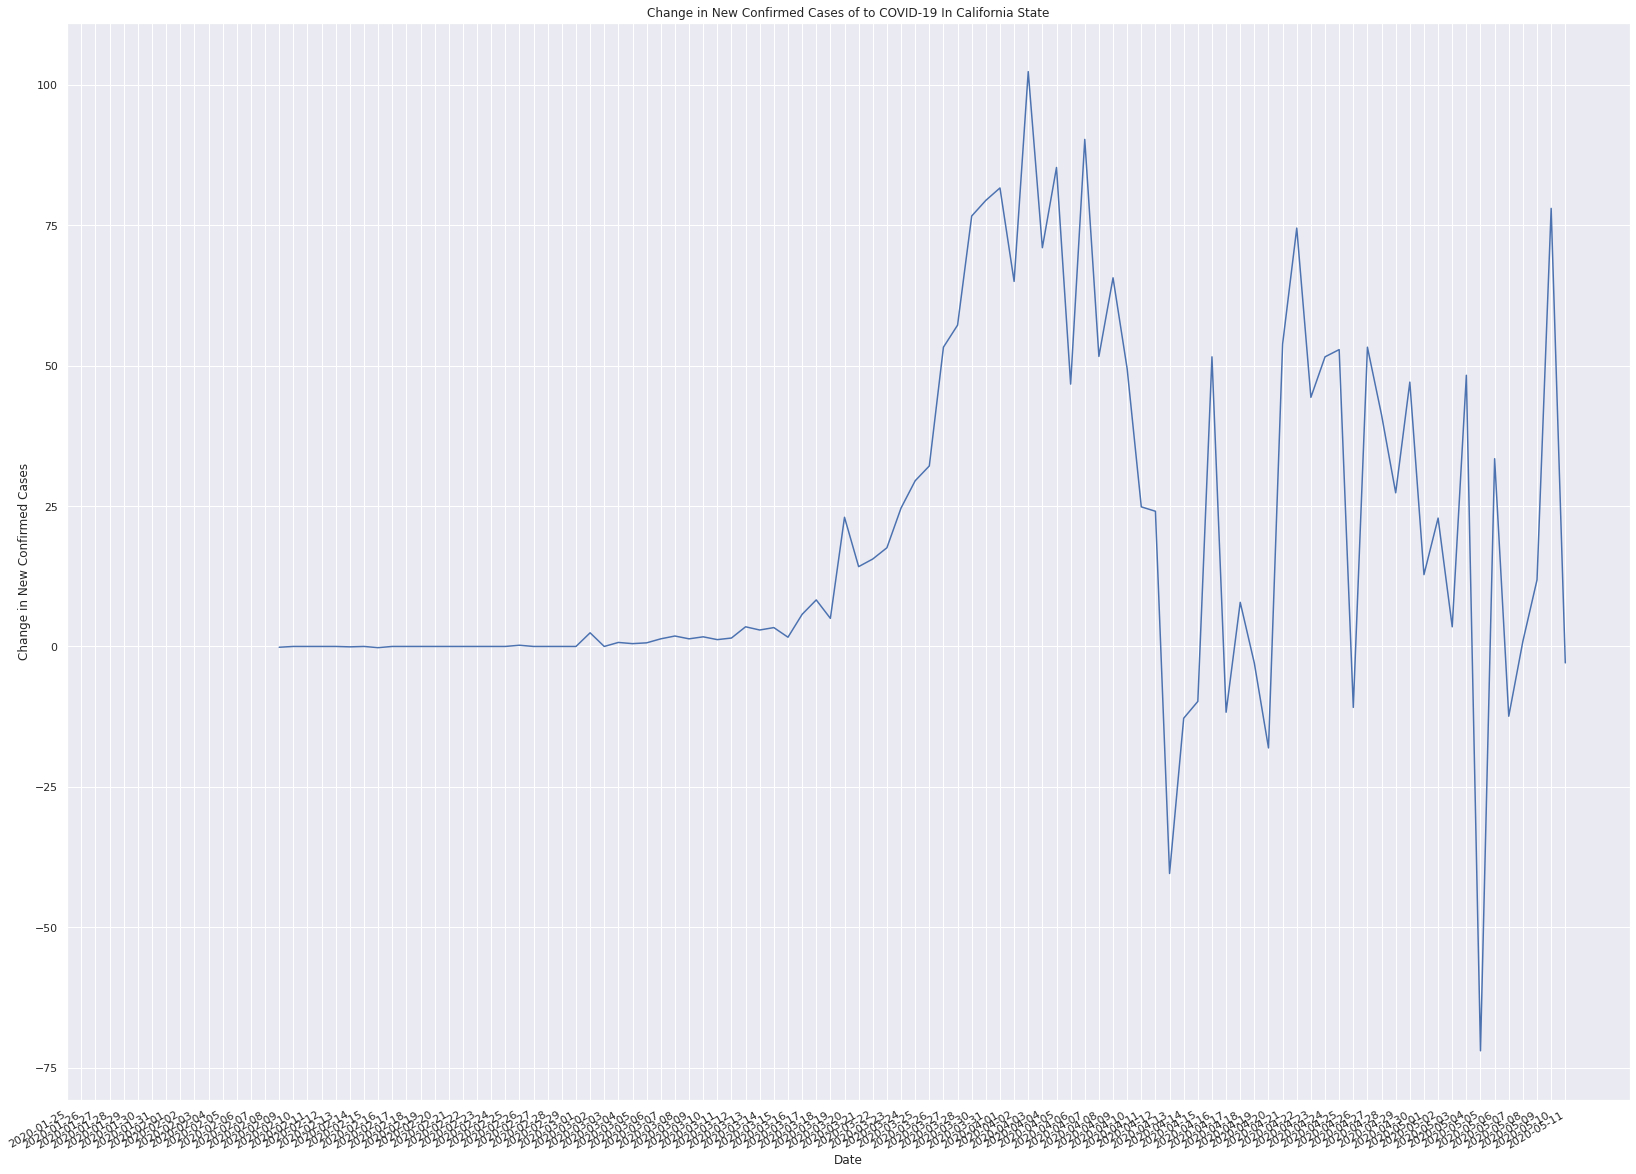

In [ ]:
covid19_dataset_uncleaned = pd.read_csv("https://raw.githubusercontent.com/datadesk/california-coronavirus-data/master/cdph-state-totals.csv")
covid19_dataset_uncleaned = covid19_dataset_uncleaned[['date','confirmed_cases','deaths']]

#Preprocess deaths and confirmed cases - there are some columns missing data
covid19_dataset_uncleaned = covid19_dataset_uncleaned[::-1]
covid19_dataset_uncleaned['delta_deaths'] = np.nan
covid19_dataset_uncleaned['new_confirmed_cases'] = np.nan
covid19_dataset_uncleaned['delta_new_confirmed_cases'] = np.nan
old_deaths = 0
old_confirmed_cases = 0
skip_first = 1
for index in covid19_dataset_uncleaned.index:
  if math.isnan(covid19_dataset_uncleaned.loc[index]['deaths']):
    covid19_dataset_uncleaned.loc[index,'deaths'] = old_deaths
  old_deaths = covid19_dataset_uncleaned.loc[index,'deaths'] 
  if math.isnan(covid19_dataset_uncleaned.loc[index]['confirmed_cases']):
    covid19_dataset_uncleaned.loc[index,'confirmed_cases'] = old_confirmed_cases
  old_confirmed_cases = covid19_dataset_uncleaned.loc[index,'confirmed_cases'] 
  if index == covid19_dataset_uncleaned.shape[0] - 1:
    continue
  else:
    covid19_dataset_uncleaned.loc[index,'delta_deaths'] = covid19_dataset_uncleaned.loc[index,'deaths'] - covid19_dataset_uncleaned.loc[index + 1,'deaths']
    covid19_dataset_uncleaned.loc[index,'new_confirmed_cases'] = covid19_dataset_uncleaned.loc[index,'confirmed_cases'] - covid19_dataset_uncleaned.loc[index + 1,'confirmed_cases']
    covid19_dataset_uncleaned.loc[index,'delta_new_confirmed_cases'] = covid19_dataset_uncleaned.loc[index,'new_confirmed_cases'] - covid19_dataset_uncleaned.loc[index + 1,'new_confirmed_cases']


covid19_dataset_uncleaned.dropna()
covid19_dataset_uncleaned['new_confirmed_cases_smooth'] = covid19_dataset_uncleaned['new_confirmed_cases'].rolling(window = 7).mean()
covid19_dataset_uncleaned['delta_new_confirmed_cases_smooth'] = covid19_dataset_uncleaned['delta_new_confirmed_cases'].rolling(window = 14).mean()
covid19_dataset_uncleaned.dropna()

#Plot Cases and Death Curve
plt.figure(figsize=(28,22))
plt.plot(covid19_dataset_uncleaned['date'],covid19_dataset_uncleaned['delta_new_confirmed_cases_smooth'])
plt.title('Change in New Confirmed Cases of to COVID-19 In California State')
plt.xlabel('Date') 
plt.ylabel('Change in New Confirmed Cases')
plt.xticks(covid19_dataset_uncleaned['date'])
plt.gcf().autofmt_xdate()
plt.show()

From the rate of change of new confirmed cases (smoothed over a 2 week window), we do not see it turn negative at all. From this, we believe that the lockdown has not had an impact in mitigating the spread of the virus.

>## <b> Sample Inference 2</b>

We have used Linear Regression to check the impact of Factors like Age and Gender on the COVID-19 deaths. We have used regression as  regression analysis allows us to describe the relationships between a set of independent variables and the dependent variable. Thus, with the coefficients that we will get from running the linear regression will show whether demographic features affected the COVID-19 situation.

If we take the problem of regression to be finding a relationship between the dependent variable y, in terms of independent variable x, we can write y as 

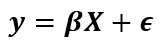


In order to calculate the beta coefficient for the Multi-Linear Regression problem, we have used the following formula


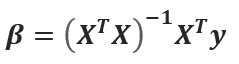

In the given dataset, as we don't have individual age and gender of all the people infected, we have used the cumalative values in age group or gender daily to find the relation.

In [ ]:
#Cells for sample inf 2

def multiple_linear_regression(input_data, output_data):
    beta_zero_array = np.ones((input_data.shape[0], 1))
    input_data = np.concatenate((beta_zero_array, input_data), 1)
    
    coeffs = np.linalg.inv(input_data.transpose().dot(input_data)).dot(input_data.transpose()).dot(output_data)

    return coeffs


> ### Gender


In [ ]:
coeffs = multiple_linear_regression(covid_demographics_df[['delta_gender_male', 'delta_gender_female']].values[:-1], covid_demographics_df['delta_deaths'].values[:-1])
coeffs

array([15.11323124,  0.03515899,  0.03181102])

Having a positive coefficient for both the number of male and female cases everyday, indicates that there is a positive correlation among the daily cases of male and female to the number of deaths each day. Thus, given the higher coefficient of male, confirms that the deaths of male population is more than that of women population in California State.

> ### Age

In [ ]:
coeffs = multiple_linear_regression(covid_demographics_df[['delta_age_0_to_17', 'delta_age_18_to_49', 'delta_age_50_to_64', 'delta_age_65_and_up']].values, covid_demographics_df['delta_deaths'].values)
coeffs

array([ 9.16463204,  0.13798674,  0.03390085, -0.08683048,  0.16942731])

This shows that people between the age 0-17 and 65+ are having high positive coefficient value (0.13798674 & 0.16942731) indicating that more people in this age group are causing the deaths to be high [High Correlation]. Age groups of 18-49 and 50-64 have significantly lesser coefficient indicating that these numbers are not responsible for majority of the deaths within the given range (from 31st March onwards). 

>## <b>Sample Inference 3 </b>


>> 
Hypothesis: We are checking if the number of the daily cases in different race ( Black, White, Asian, Latino ) follow the same distribution. We are able to check this as we have the % of cases for each race in the dataset and hence can get the number of daily cases.
<br>
<b> Test Used : KS Test </b> <br>
We are using 2 sample KS test as it has no assumptions about the underlying distribution of the data and compares if 2 dataset are from the same distribution. We are using value of 0.4 to reject/ accept hypothesis.
<br>
If this test proves to be helpful in stating whether 2 race's follow the same distribution we can use this to predict the number of cases for say a neighbourhood 'A' which has a dominent race living in it on comparing to neighbourhood 'B' which has the other dominant race living in it.

In [ ]:
def get_monthly_data(df, date_from, date_to, column):
  month_df = df[df['date'] >  date_from]
  month_df = month_df[month_df['date'] < date_to]
  month_df['count_col'] = month_df[column]*month_df['confirmed_cases_day']
  month_list = np.array(month_df['count_col'])
  return month_list

In [ ]:
white_cases = get_monthly_data(covid_df, pd.Timestamp(2020, 4,9), pd.Timestamp(2020, 5,7), 'white_cases_percent')
black_cases = get_monthly_data(covid_df, pd.Timestamp(2020, 4,9), pd.Timestamp(2020, 5,7), 'black_cases_percent')
latino_cases = get_monthly_data(covid_df, pd.Timestamp(2020, 4,9), pd.Timestamp(2020, 5,7), 'latino_cases_percent')
asian_cases = get_monthly_data(covid_df, pd.Timestamp(2020, 4,9), pd.Timestamp(2020, 5,7), 'asian_cases_percent')

In [ ]:
print('2 sample KS test to compare distribution of black and white cases ', run_2_sample_ks_test(black_cases, white_cases))
print('2 sample KS test to compare distribution of black and asian cases ', run_2_sample_ks_test(black_cases, asian_cases))
print('2 sample KS test to compare distribution of black and latino cases ', run_2_sample_ks_test(black_cases, latino_cases))
print('2 sample KS test to compare distribution of white and asian cases ', run_2_sample_ks_test(white_cases, asian_cases))
print('2 sample KS test to compare distribution of white and latino cases ', run_2_sample_ks_test(white_cases, latino_cases))
print('2 sample KS test to compare distribution of latino and asian cases ', run_2_sample_ks_test(latino_cases, asian_cases))

print('Since the KS statistic value for each distribution is > 0.4, we reject the hypothesis that the distributions for number cases per race are the same.')

2 sample KS test to compare distribution of black and white cases  1.0
2 sample KS test to compare distribution of black and asian cases  0.8695652173913044
2 sample KS test to compare distribution of black and latino cases  1.0
2 sample KS test to compare distribution of white and asian cases  0.8695652173913044
2 sample KS test to compare distribution of white and latino cases  0.5652173913043479
2 sample KS test to compare distribution of latino and asian cases  0.9130434782608696
Since the KS statistic value for each distribution is > 0.4, we reject the hypothesis that the distributions for number cases per race are the same.
